# M5 Forecasting - Accuracy 

In this project, we will predict the unit sales of various products sold in Walmart.
We are provided with five datasets, which is explained in https://www.kaggle.com/c/m5-forecasting-accuracy/data.

There are 10 stores (four in California, three in Texas and three in Wisconsin), 3 item categories (Hobbies, Household and Foods)
and finally, 7 deparments (two for Hobbies, two for Household and three for Foods).

The following steps are going to be taken:

1. Reduce the memory usage through downcasting.
2. Visualize and understand the data by item and store categories.
3. Melt, combine and encode data to better fit to the future models.
4. Utilize three LightGBM models by
    1. stores
    2. stores and item categories
    3. stores and departments 
5. Forecast the unit sales of the products and ensemble the final predictions.

## 1. Downcast and Visualize the Data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
# Memory profilers to see memory usage

def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30,2)

def size_of_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [3]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
df_calendar = pd.read_csv('calendar.csv')
df_calendar = reduce_mem_usage(df_calendar)

Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [5]:
df_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
df_calendar.wm_yr_wk.unique().shape
# 282 weeks total (about 5 years)

(282,)

In [5]:
# wm_yr_wk is the unique ordinal number of the week, for all the years. 
# you have an unique value of wm_yr_wk for each 7 days, from Saturday to Friday.

In [6]:
df_validation = pd.read_csv('sales_train_validation.csv')
df_validation = reduce_mem_usage(df_validation)

Mem. usage decreased to 95.00 Mb (78.7% reduction)


In [7]:
df_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


### Visualize by item categories

<AxesSubplot:title={'center':'Average sales by item categories'}>

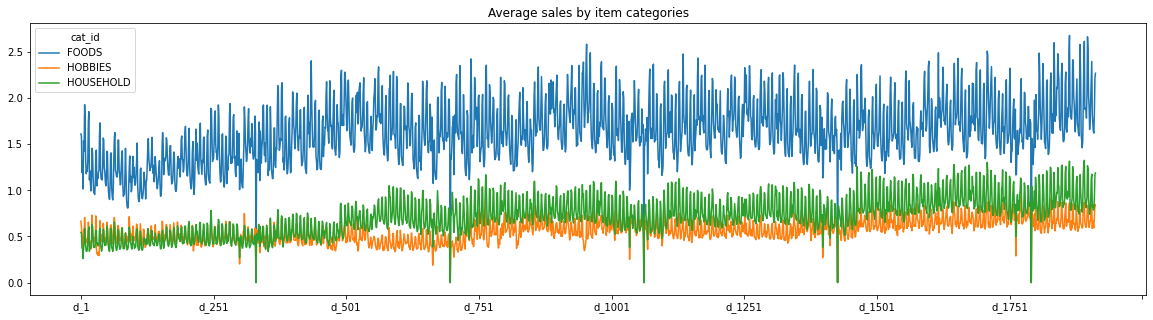

In [13]:
# number of sales by item catergories

df_validation.groupby('cat_id').mean().T.plot(figsize = (20,5), title = 'Average sales by item categories')

<AxesSubplot:title={'center':'Total sales by item categories'}>

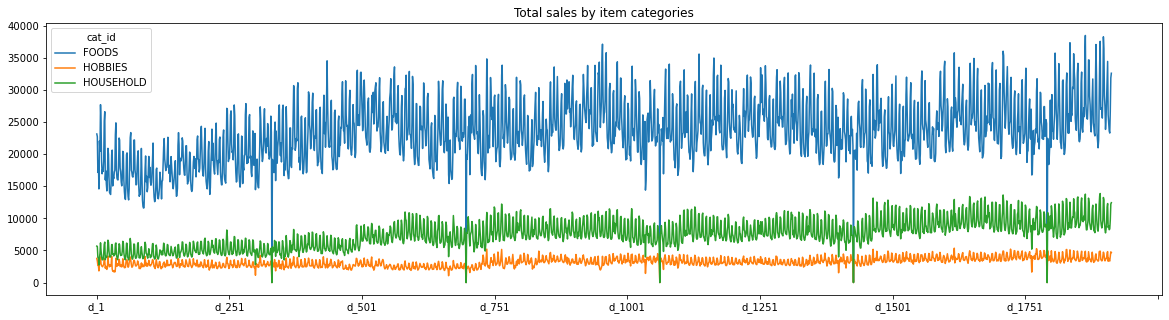

In [14]:
df_validation.groupby('cat_id').sum().T.plot(figsize=(20,5), title = 'Total sales by item categories')

### Visualize by store categories

In [15]:
df_val_transposed = df_validation.set_index('id').T
df_val_transposed.index.rename('d', inplace = True)

df_validation_cal = pd.merge(df_val_transposed, df_calendar, on = 'd').set_index('date')

item_col = np.array(df_validation['id'])
item_col

df_validation_cal = df_validation_cal[item_col]

In [16]:
df_validation_cliped = df_validation_cal.clip(0,1)


In [17]:
df_validation_cliped

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,1,1,0,...,0,1,1,0,1,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,0,0
2011-01-31,0,0,0,0,0,0,0,0,1,1,...,0,1,1,0,1,1,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,1,1,0,1,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,1,1,1,0,1,0,1,1,0,0,...,1,1,1,0,0,0,0,1,1,0
2016-04-21,1,0,0,1,1,0,0,1,0,0,...,1,1,1,0,1,1,0,0,0,0
2016-04-22,0,0,1,1,1,1,0,1,0,1,...,0,1,1,0,1,0,0,0,1,0


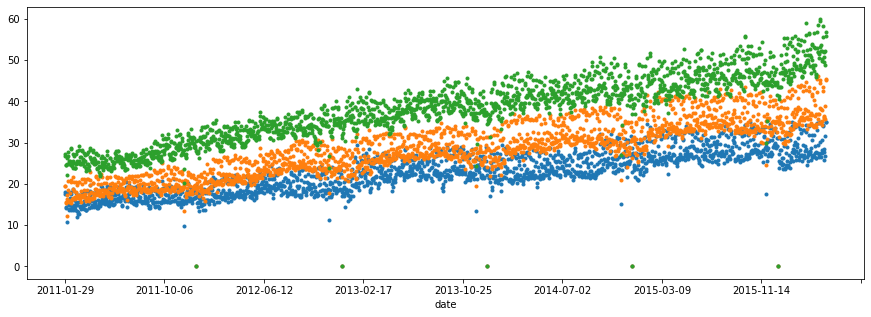

In [18]:
for i in df_validation['cat_id'].unique():
    items = [c for c in df_validation_cliped.columns if i in c]
    (df_validation_cliped[items].mean(axis=1)*100).plot(figsize=(15,5),style = '.')

<AxesSubplot:xlabel='cat_id'>

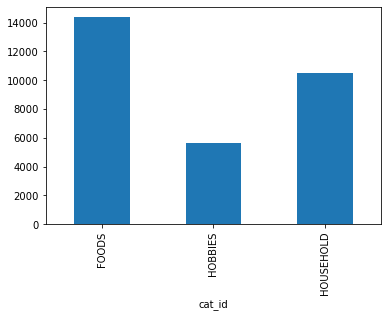

In [19]:
# counting the number of rows for each cat_id.
df_validation.groupby('cat_id').count()['id'].plot(kind='bar')

In [21]:
date_col = df_calendar.iloc[:,0]
date_col

0       2011-01-29
1       2011-01-30
2       2011-01-31
3       2011-02-01
4       2011-02-02
           ...    
1964    2016-06-15
1965    2016-06-16
1966    2016-06-17
1967    2016-06-18
1968    2016-06-19
Name: date, Length: 1969, dtype: object

In [22]:
df_validation.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [37]:
# Price Dataframe

In [23]:
df_price = pd.read_csv('sell_prices.csv')
df_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [24]:
stores = np.array(df_price['store_id'].unique())
stores

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

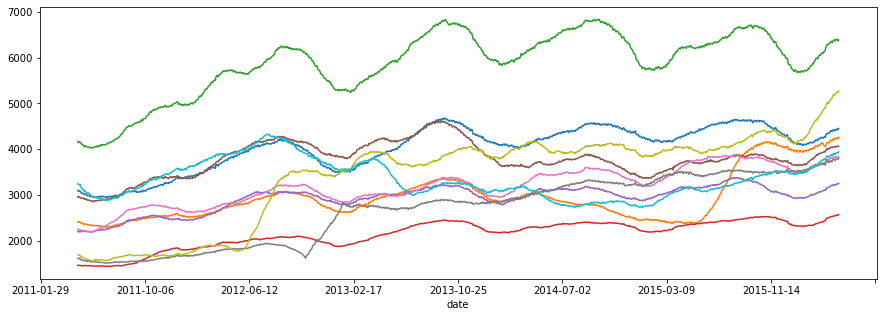

In [25]:
# Moving Average with window size 90
for store in stores:
    items = [c for c in df_validation_cal.columns if store in c]
    df_validation_cal[items].sum(axis = 1).rolling(90).mean().plot(figsize = (15,5))

Above graph corresponds to the business cycle, where the oscillation is driven by economic recession and expansion, but the general trend is upward sloping.

## 2. Melt, combine and encode data

In [26]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1941         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [27]:
########################### Load Data
#################################################################################
print('Load Main Data')

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv('sales_train_evaluation.csv')
prices_df = pd.read_csv('sell_prices.csv')
calendar_df = pd.read_csv('calendar.csv')

Load Main Data


In [1]:
########################### Make Grid
#################################################################################
print('Create Grid')

# We can tranform horizontal representation representation
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, id_vars = index_columns, var_name = 'd', value_name = TARGET)

Create Grid


NameError: name 'pd' is not defined

In [ ]:
# If we look on train_df we se that 
# we don't have a lot of traning rows
# but each day can provide more train data

print('Train rows:', len(train_df), len(grid_df))

In [ ]:
add_grid = pd.DataFrame()

for i in tqdm(range(1,29)):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_' + str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid=pd.concat([add_grid, temp_df])
    
grid_df = pd.concat([grid_df, add_grid])

In [ ]:
grid_df = grid_df.reset_index(drop=True)
grid_df

In [ ]:
# remove some temporary DFs
del temp_df, add_grid

# We won't need the original train_df
del train_df

In [ ]:
# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',size_of_fmt(grid_df.memory_usage(index=True).sum())))


In [ ]:
 We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data

for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')
    
# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',size_of_fmt(grid_df.memory_usage(index=True).sum())))
# Decreased the memory usage by almost 1/3 of the original data

In [ ]:
grid_df

In [ ]:
########################## Product Release date
#################################################################################
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# 'absence' for the item in the store
# we can save some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id', 'item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id', 'item_id', 'release']